In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import torch 
import torchvision
import numpy as np

In [3]:
df = pd.read_csv('./data/train.csv')

In [4]:
df_train, df_valication = train_test_split(df, test_size=0.3, random_state=42)

In [5]:
type(df_train)

pandas.core.frame.DataFrame

In [6]:
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
710,Train_710,1,0,0,0
1323,Train_1323,0,0,0,1
979,Train_979,1,0,0,0
118,Train_118,0,0,1,0
1144,Train_1144,0,0,1,0


In [7]:
df_valication.head()

,image_id,healthy,multiple_diseases,rust,scab
1511,Train_1511,0,0,1,0
1799,Train_1799,1,0,0,0
135,Train_135,1,0,0,0
408,Train_408,0,0,1,0
1693,Train_1693,1,0,0,0


In [8]:
int(df_valication.iloc[0,1:].values.argmax())
# np.where(df_valication.iloc[0,1:].to_numpy() == 1)[0]

2

In [9]:
from dataframe import CustomDataset
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
classes_list = ['healthy', 'multiple_diseases', 'rust', 'scab']

In [11]:
csv_file = './data/validation/validation.csv'
images_dir = './data/validation/images'
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Измените размер изображений
    transforms.ToTensor(),            # Преобразование в тензор
])

# Создание кастомного датафрейма
val_dataset = CustomDataset(csv_file, images_dir, classes_list, transform)

In [14]:
csv_file = './data/train/train.csv'
images_dir = './data/train/images'
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Измените размер изображений
    transforms.ToTensor(),            # Преобразование в тензор
])

# Создание кастомного датафрейма
train_dataset = CustomDataset(csv_file, images_dir, classes_list, transform)

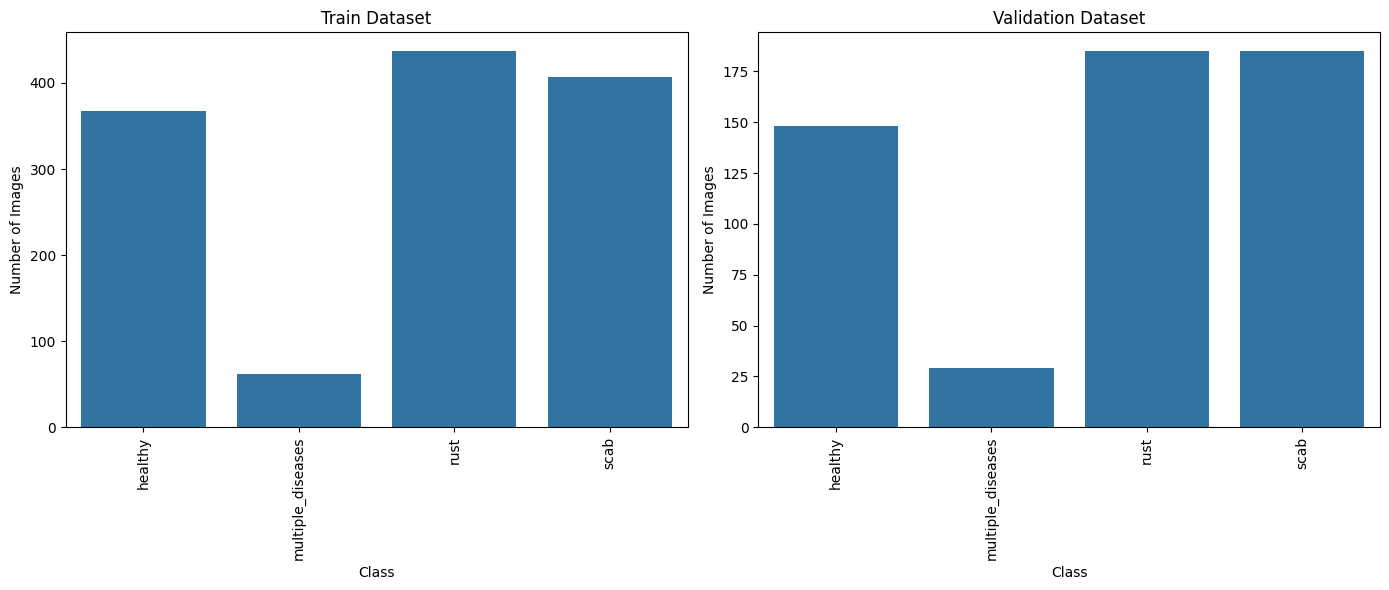

In [15]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
    train_class_counts[label] += 1

# Подсчитать количество изображений в каждом классе для валидационного набора данных
val_class_counts = np.zeros(len(val_dataset.classes))
for _, label in val_dataset:
    val_class_counts[label] += 1

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=val_dataset.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# фиксируем рандомный сид
seed  = 20
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

In [ ]:
# детектируем девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device